## 1 Introduction
Before starting this example, you should be familiar with Azure Machine Learning (Azure ML) experiments and the process for publishing Azure web service from Python notebooks. 

The purpose of this example is to demonstrate how to use a feature selection technique not available for Azure ML experiments. This process can be completed with Azure ML Jupyter notebook, a cloud-based service that's part of Azure ML environment.

As [Figure 1][pic 1] shows, there are three Feature Selection options for an Azure ML experiment:
 1. Filter Based Feature Selection
 2. Fisher Linear Discriminant Analysis
 3. Permutation Feature Importance

Among these, Fisher Linear Discriminant Analysis is actually a dimension reduction technique for cases where the response variable is categorical. Filter Based Feature Selection uses univariate analysis to select features (using metrics such as Pearson Correlation, Chi Squared, etc). Permutation Feature Importance ranks variables by calculating the difference in model performance metrics before and after random permutations of feature values. As the paper [Dimension Reduction vs. Variable Selection][paper link] describes, there are a wide variety of feature selection and dimension reduction techniques. In what follows we'll illustrate how to use recursive feature elimination within an Azure ML Jupyter notebook. 

[![Figure 1][pic 1]][pic 1] Figure 1

[paper link]: http://rd.springer.com/chapter/10.1007%2F11558958_113
[pic 1]: https://az712634.vo.msecnd.net/notebooks/4e5ae462-71c1-11e5-8c01-a96769336daf.PNG

## 2 Read data
In this example we'll be using the Boston Housing dataset. There are 506 rows in the dataset. The target variable is median home price. There are 13 predictor variables including average number of rooms per dwelling, crime rate by town, etc. More information about this dataset can be found at [UCI][uci link].
[uci link]: https://archive.ics.uci.edu/ml/datasets/Housing

In [1]:
from sklearn.datasets import load_boston
boston = load_boston()
X = boston.data
y = boston.target
feature_names = boston.feature_names
print(X.shape)
print(y.shape)
print(feature_names)

(506, 13)
(506,)
['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


## 3 Recursive Feature Elimination
The sklearn package has several feature selection methods and details can be found at the [documentation][feature link] site. In this example we'll be using the recursive feature elimination method. This process starts with all variables and assigns weights to them. Those with small weights are first removed. The remaining variables are used to refit the model and the process repeats. 

We start by importing the packages that'll be used. 

[feature link]: http://scikit-learn.org/stable/modules/feature_selection.html

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.feature_selection import RFECV

The following lines of code first scale the features then identify the selected features with recursive feature elimination.

Optimal number of features : 6
Features selected: ['CRIM', 'NOX', 'RM', 'DIS', 'PTRATIO', 'LSTAT']


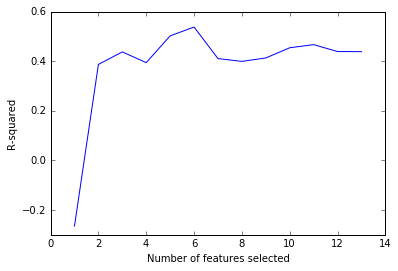

In [3]:
# initiate the linear model
lm = LinearRegression()

# scale the features
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled_minmax = min_max_scaler.fit_transform(X)
x_scaled_minmax_df = pd.DataFrame(x_scaled_minmax, columns = feature_names)

# recursive feature elimination with cross validation, using r-squared as metric
rfecv = RFECV(estimator=lm, step=1, cv=5, scoring='r2')
rfecv.fit(x_scaled_minmax_df, y)

# print the optimal number of feature
print("Optimal number of features : %d" % rfecv.n_features_)

# save the selected features
feature_cols_selected = list(np.array(feature_names)[rfecv.support_])
print("Features selected: " + str(feature_cols_selected))

# plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("R-squared")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

Once the features to include are selected, we can use them to fit the model. While the scaled features were used in the RFE step above, we'll use the original values for fitting the model. This way we don't have to tranform the data when making predictions.

In [4]:
#%% fit model with selected features
X_new = X[:,rfecv.support_]
lm2 = LinearRegression()
lm2.fit(X_new, y)

# print the R-squared
print("The R-squared value is: {0:0.4f} \n".format(lm2.score(X_new, y)))
# save intercept and coefficients
param_df = pd.DataFrame({"Features": ['intercept'] + feature_cols_selected, "Coef": [lm2.intercept_] + list(lm2.coef_)})
cols = param_df.columns.tolist()
cols = cols[-1:]+cols[:-1]
param_df = param_df[cols]
print(param_df)

The R-squared value is: 0.7113 

    Features       Coef
0  intercept  35.629382
1       CRIM  -0.071002
2        NOX -17.043777
3         RM   4.246403
4        DIS  -1.204040
5    PTRATIO  -1.001903
6      LSTAT  -0.554361


Next we'll use the model to make predictions. Typically, predictions are done on a validation dataset. Here, however, the training dataset is used for illustraton purposes.

In [5]:
# assign test data
newX = X_new
newY = y

# make predictions
predicted = lm2.predict(newX)
predictedDf = pd.DataFrame({"predicted": predicted})

# dataframe for X
newXDf = pd.DataFrame(newX)
newXDf.columns = feature_cols_selected
# dataframe for y
newYDf = pd.DataFrame(newY)
newYDf.columns = ['MEDV']
# join X, y and prediction
mydata_with_pd = newXDf.join(newYDf).join(predictedDf)
mydata_with_pd.head()

,CRIM,NOX,RM,DIS,PTRATIO,LSTAT,MEDV,predicted
0,0.00632,0.538,6.575,4.0900,15.3,4.98,24.0,31.365126
1,0.02731,0.469,6.421,4.9671,17.8,9.14,21.6,26.018747
2,0.02729,0.469,7.185,4.9671,17.8,4.03,34.7,32.095787
3,0.03237,0.458,6.998,6.0622,18.7,2.94,33.4,29.872827
4,0.06905,0.458,7.147,6.0622,18.7,5.33,36.2,29.178013


In [6]:
# check performance metrics
import numpy as np
obs = mydata_with_pd.MEDV
pred = mydata_with_pd.predicted

mae = np.mean(abs(pred-obs))
rmse = np.sqrt(np.mean((pred-obs)**2))
rae = np.mean(abs(pred-obs))/np.mean(abs(obs-np.mean(obs)))
rse = np.mean((pred-obs)**2)/np.mean((obs-np.mean(obs))**2)

print("Mean Absolute Error: {0:0.6f}".format(mae))
print("Root Mean Squared Error: {0:0.6f}".format(rmse))
print("Relative Absolute Error: {0:0.6f}".format(rae))
print("Relative Squared Error: {0:0.6f}".format(rse))

Mean Absolute Error: 3.467774
Root Mean Squared Error: 4.936601
Relative Absolute Error: 0.521689
Relative Squared Error: 0.288678


## 4 Web Service
### 4.1 Set up a web service
After developing the model, we can deploy it as a service so others can use it. The "azureml" package's services subpackage can be used for this purpose. The following lines of code are setting up a web service named "demoservice". Notice that you should enter your own workspace\_id and authorization\_token. Your returned API information should be different from the printout below. 

In [7]:
# extract workspace info
from azureml import Workspace
ws = Workspace()
workdspace_id = ws.workspace_id
authorization_token = ws.authorization_token

# set up web service
from azureml import services
@services.publish(workdspace_id, authorization_token)
@services.types(crim = float, nox=float, rm=float, dis=float, ptratio=float, lstat=float)
@services.returns(float)
def demoserviceVarSel(crim, nox, rm, dis, ptratio, lstat):
    feature_vector = [crim, nox, rm, dis, ptratio,  lstat]
    return lm2.predict(feature_vector)

In [8]:
service_url = demoserviceVarSel.service.url 
api_key = demoserviceVarSel.service.api_key
help_url = demoserviceVarSel.service.help_url
service_id = demoserviceVarSel.service.service_id

### 4.2 Consume a web service

The purpose of the following code is to wait a few seconds so that the web service is successfully desployed and ready for consumption.

In [9]:
# wait 
import time
time.sleep(10)

The code below can be used to consume the web service. For illustration purpose the data for two records are provided.

In [10]:
import urllib2
# If you are using Python 3+, import urllib instead of urllib2

import json 


data =  {

        "Inputs": {

                "input1":
                {
                    "ColumnNames": ["crim", "lstat", "nox", "rm", "ptratio", "dis"],
                    "Values": [ [ "0.00632", "4.98", "0.538", "6.575", "15.3", "4.0900" ], 
                               [ "0.02731", "9.14", "0.469", "6.421", "17.8", "4.9671" ], ]
                },        },
            "GlobalParameters": {
}
    }

body = str.encode(json.dumps(data))

url = service_url
api_key = api_key # Replace this with the API key for the web service

headers = {'Content-Type':'application/json', 'Authorization':('Bearer '+ api_key)}

req = urllib2.Request(url, body, headers) 

try:
    response = urllib2.urlopen(req)

    # If you are using Python 3+, replace urllib2 with urllib.request in the above code:
    # req = urllib.request.Request(url, body, headers) 
    # response = urllib.request.urlopen(req)

    result = response.read()
    print(result) 
except urllib2.HTTPError, error:
    print("The request failed with status code: " + str(error.code))

    # Print the headers - they include the requert ID and the timestamp, which are useful for debugging the failure
    print(error.info())

    print(json.loads(error.read()))                 


{"Results":{"output1":{"type":"table","value":{"Values":[["31.3651262005007"],["26.018746711909"]]}},"output2":{"type":"table","value":{"Values":[["data:text/plain,","data:text/plain,",null]]}}}}


The above service consumption code is based on those at the help\_url, which contains, among others, sample code written in C#, Python, and R for consuming the web service. To check out the code for yourself, copy the help\_url value to a new browser to open the web page. Scroll down the newly opened page till you see the section "Sample Code." Click on the Python tab and you'll see the sample code. Two changes were made to the sample code:
    1. Fill in the url and api_key with the values returned for the current web service, and 
    2. Enter the values for the first two records. Notice that the order of the columns here may be different from 
    that in your definition of the web service. 

## 5 Conclusion
In this example we started by briefly reviewing the feature selection techniques available for Azure ML's experiments. Then we used the Boston housing dataset to illustrate how to use a technique that's not available for Azure ML's experiments: recursive feature selection. The sklearn package implements several other feature techniques and you can find more information from the [documentation][documentation link] site.

[documentation link]: http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection